In [1]:
# Bibliotecas necessárias para o experimento

import numpy as np
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random

In [2]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 400

In [3]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [4]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [5]:
def lind(u, Ut, Uf, t, lbda):
    n = 0.5005
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    fx=field(Ut, Uf, u[0], 0.35, Ax, B)
    fy=field(Ut, Uf, u[1], 0.31, Ay, B)
    fz=field(Ut, Uf, u[2], 0.34, Az, B)
    P=400

    if abs(fx) > P:
        if fx < 0:
            fx = -P
        else:
            fx = P
    if abs(fy) > P:
        if fy < 0:
            fy = -P
        else:
            fy = P
    if abs(fz) > P:
        if fz < 0:
            fz = -P
        else:
            fz = P

    F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [6]:
def rungeKutta(u, Ut, Uf, h, t, lbda):
    fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
    k1 = np.dot(k1,Ut)
    fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
    k2 = np.dot(k2,(Ut+h/2*k1))
    fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
    k3 = np.dot(k3,(Ut+h/2*k2))
    fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
    k4 = np.dot(k4,(Ut+h*k3))
    a = fx;
    b = fy;
    c = fz;
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [7]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [8]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [9]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [10]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [11]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [12]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [13]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [14]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])
                
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [15]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [16]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [17]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [18]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

############ Informações finais do experimento ############

O rf desejado é:
 [[0]
 [0]
 [1]]
O rho desejado é: [[np.float64(1.0), np.complex128(0j)], [np.complex128(0j), np.float64(0.0)]]


/tmp/ipykernel_68775/116918231.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  f = -a*SA-h*(SB/SA)


Valores especiais: [np.float64(0.0), np.float64(0.0), np.float64(353.40300042371007), 0.35, 0.31, 0.34]
Valores especiais: [np.float64(0.0), np.float64(0.0), np.float64(0.0), 0.35, 0.31, 0.34]
Valores especiais: [np.float64(0.0), np.float64(0.0), np.float64(0.0), 0.35, 0.31, 0.34]
Valores especiais: [np.float64(1.5474860681462055e-185), np.float64(0.00030362438393331863), np.float64(0.0), 0.35, 0.31, 0.34]
Valores especiais: [np.float64(346.66213338546453), np.float64(0.0), np.float64(0.0), 0.35, 0.31, 0.34]
Valores especiais: [np.float64(50.14599632153964), np.float64(0.0), np.float64(0.0), 0.35, 0.31, 0.34]
Valores especiais: [np.float64(0.3307806558015058), np.float64(0.0), np.float64(0.0), 0.35, 0.31, 0.34]
Valores especiais: [np.float64(0.0), np.float64(0.0), np.float64(27.996793337142023), 0.35, 0.31, 0.34]
Valores especiais: [np.float64(46.310248147052135), np.float64(0.0), np.float64(0.0), 0.35, 0.31, 0.34]
Valores especiais: [np.float64(0.0), np.float64(51.17845012260132), np.

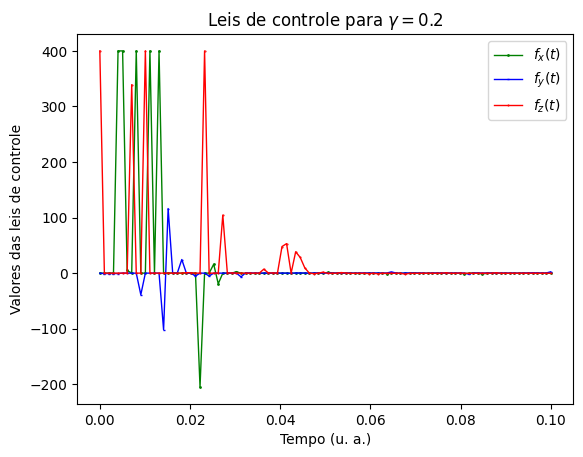

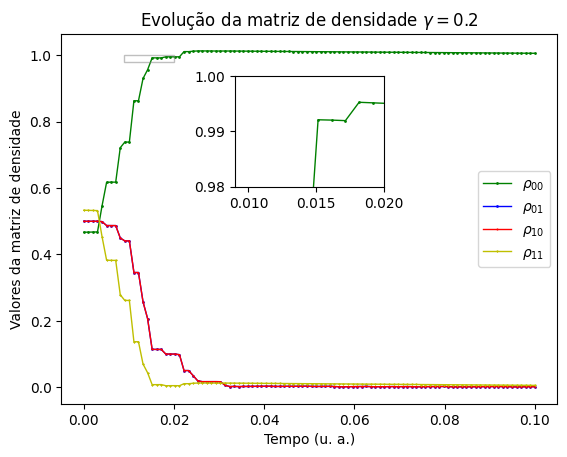

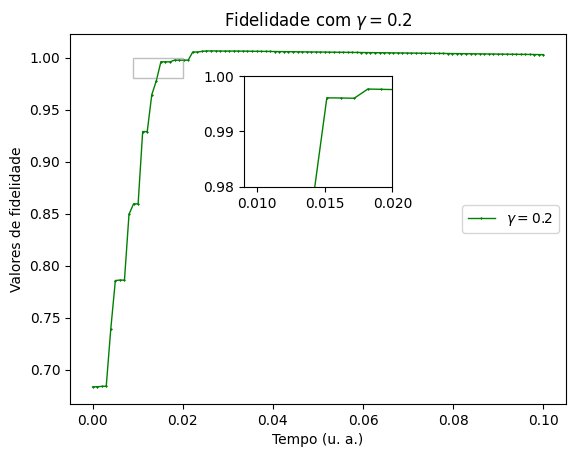

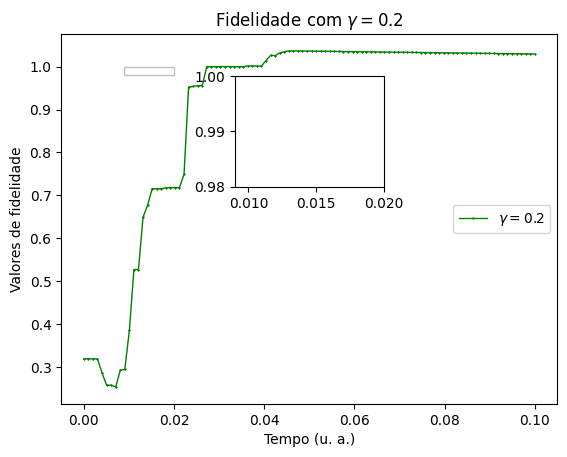

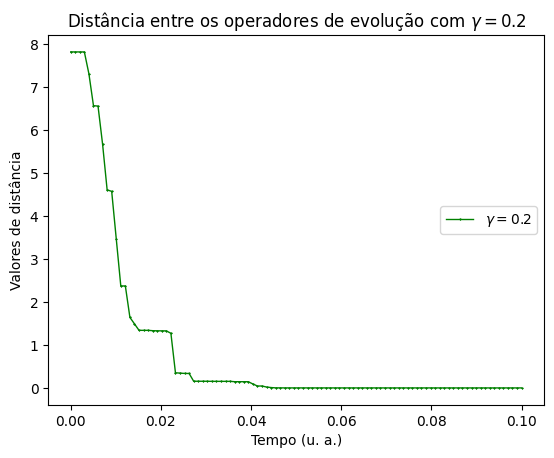

In [19]:
u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard

Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard

print(f"############ Informações finais do experimento ############\n")

r0 = [[1], [0], [0]]
rf = np.dot(Uf, r0)
print(f'O rf desejado é:\n {rf}')
pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
print(f'O rho desejado é: {pf}')

h=0.001
t=0
i=0
lbda=0.2
# Proposta do algoritmo genético
resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
u[0] = resultado_algoritmo_genetico[0]
u[1] = resultado_algoritmo_genetico[1]
u[2] = resultado_algoritmo_genetico[2]
distance_vector = []
fx_vector = []
fy_vector = []
fz_vector = []
rho_vector = np.zeros((4,100),dtype=np.complex128)
fid_vector = []
fid_autores = []
   
while t < 100:
    print(f"Valores especiais: {u}")
    a,b,c,Ut = rungeKutta(u, Ut, Uf, h, t, lbda)
    D = np.linalg.norm(Ut-Uf)**2
    distance_vector.append(D)
    fx_vector.append(a)
    fy_vector.append(b)
    fz_vector.append(c)
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    rho_vector[0][t] = pt[0][0]
    rho_vector[1][t] = pt[0][1]
    rho_vector[2][t] = pt[1][0]
    rho_vector[3][t] = pt[1][1]
    fid_vector.append(np.trace(np.sqrt(np.sqrt(pt)*pf*np.sqrt(pt))))
    fid_autores.append((np.trace(np.dot(Ut, np.transpose(Ut)))+np.abs(np.trace(np.dot(np.transpose(Uf), Ut)))**2)/(3*(3+1)))
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    t += 1

rt = np.dot(Ut, r0)
print(f'O vetor de Bloch encontrado é:\n {rt}')
pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
print(f'O rho alcançado foi:\n {pt}')
print(f'A fidelidade do experimento é de: {np.trace(np.sqrt(np.sqrt(pt)*pf*np.sqrt(pt)))}')
print(f'A fidelidade do experimento é de (fórmula dos autores do artigo): {(np.trace(np.dot(Ut, np.transpose(Ut)))+np.abs(np.trace(np.dot(np.transpose(Uf), Ut)))**2)/(3*(3+1))}')
print(f'O vetor U alcançado foi:\n {Ut}')
print(f'A distância encontrada, ao final do experimento foi: {D}')

print(f"\n############ Informações gráficas obtidas com o experimento ############\n")

leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
densidade(rho_vector,t,lbda)
fidelidade(fid_vector,t,lbda)
fidelidade(fid_autores,t,lbda)
distance(distance_vector,t,lbda)

In [20]:
print(f"\n############ Informações provenientes de análises gráficas ############\n")

time = 0
for i in range(len(rho_vector[0])):
    if rho_vector[0][i] == max(abs(rho_vector[0])):
        time = i
        break
print(fr"O maior valor obtido para ρ, na primeira posição da matriz, foi {max(abs(rho_vector[0]))} para o tempo de {time/1000}, com fidelidade de {np.abs(fid_vector[time])} e de acordo com a fórmula dos autores, com fidelidade de {np.abs(fid_autores[time])}")


############ Informações provenientes de análises gráficas ############

O maior valor obtido para ρ, na primeira posição da matriz, foi 1.0129565708285346 para o tempo de 0.026, com fidelidade de 1.0064574361733012 e de acordo com a fórmula dos autores, com fidelidade de 0.9558588981365683


In [21]:
print(fid_autores)

[np.float64(0.3190466557286069), np.float64(0.3190260842745786), np.float64(0.31900540787448645), np.float64(0.31898462935568), np.float64(0.2860966050899842), np.float64(0.25760845948906097), np.float64(0.2573559629188997), np.float64(0.2535569734812562), np.float64(0.29231504885748083), np.float64(0.2943887855592179), np.float64(0.38564683310748715), np.float64(0.5270950274945493), np.float64(0.5270226120193179), np.float64(0.6489278860271425), np.float64(0.6767117972033837), np.float64(0.7153346120953006), np.float64(0.7152936683921967), np.float64(0.7151842725776523), np.float64(0.717514459463186), np.float64(0.7179248151419562), np.float64(0.7180865233496426), np.float64(0.7180997381616826), np.float64(0.7487993081712386), np.float64(0.9517860053726012), np.float64(0.9537348350030036), np.float64(0.955481114227562), np.float64(0.9558588981365683), np.float64(0.9999682835930351), np.float64(0.9998444812581798), np.float64(0.999813196523815), np.float64(0.9997033590179437), np.float

In [22]:
print(sum(fid_autores[20:])/(len(fid_autores)-20))

1.01193407895756


In [23]:
print(fid_vector)

[np.complex128(0.6832923570767023+0j), np.complex128(0.6835271185047228+0j), np.complex128(0.6837586550341794+0j), np.complex128(0.683987040503832+0j), np.complex128(0.7391687312379108+0j), np.complex128(0.7856178835299952+0j), np.complex128(0.7860505135701629+0j), np.complex128(0.7859703080156644+0j), np.complex128(0.8493874964805962+0j), np.complex128(0.859356625697541+0j), np.complex128(0.8593140025186491+0j), np.complex128(0.9288971594847109+0j), np.complex128(0.9288610012324027+0j), np.complex128(0.9643204156853815+0j), np.complex128(0.9778341954488201+0j), np.complex128(0.9960251304502966+0j), np.complex128(0.9959952583974448+0j), np.complex128(0.995947249466258+0j), np.complex128(0.9976079072482914+0j), np.complex128(0.9975581815094873+0j), np.complex128(0.9975084718150187+0j), np.complex128(0.9976382812723031+0j), np.complex128(1.0054418450734306+0j), np.complex128(1.005390705883138+0j), np.complex128(1.006026903980625+0j), np.complex128(1.0064145139935057+0j), np.complex128(1.

In [24]:
print(sum(fid_vector[20:])/(len(fid_vector)-20))

(1.0046150222078611+0j)


In [25]:
print(distance_vector)

[np.float64(7.818728472906441), np.float64(7.818498957590644), np.float64(7.8182680098104775), np.float64(7.81803566768526), np.float64(7.308136925212047), np.float64(6.567997463406535), np.float64(6.558012531418885), np.float64(5.672739299746294), np.float64(4.609488461523856), np.float64(4.5735582327920055), np.float64(3.472349367476516), np.float64(2.373055966988273), np.float64(2.3729128589536335), np.float64(1.641629582001307), np.float64(1.4911258138687664), np.float64(1.3408662629051087), np.float64(1.340492793651393), np.float64(1.3404686594854351), np.float64(1.3323310247522686), np.float64(1.3296611904261497), np.float64(1.3282568765918332), np.float64(1.3276091941787058), np.float64(1.2719000077216074), np.float64(0.35273173747930764), np.float64(0.3452993345658769), np.float64(0.33794554335080307), np.float64(0.3368786321664624), np.float64(0.15622092559284811), np.float64(0.15615524827068633), np.float64(0.1557172779622073), np.float64(0.1555962651184133), np.float64(0.153

In [26]:
print(sum(distance_vector[20:])/(len(distance_vector)-20))

0.0942003316412587
